In [10]:
import json
import multiprocessing
import numpy as np
import os
import pandas as pd
import time

In [2]:
# Set current working directory
os.chdir("../cord_19_dataset")
os.getcwd()

'/home/nrs/SideProjects/COVID19_Research_Analysis/cord_19_dataset'

In [ ]:
metadata_filename = "metadata.csv"
metadata_cols = list(pd.read_csv(metadata_filename, nrows=0).columns)
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_df = pd.read_csv(metadata_filename, dtype=metadata_cols_dtypes)

**Dask Dataframes**<br>
How to use Dask to deal with dataframes that don't fit in memory? We'll find out here.

Dask is a parallel computing library (one machine or distributed) that offers abstractions to **work with numpy and pandas datasets larger than a single machine's memory through parallel computation**. Numpy, pandas, and sklearn were not designed to scale beyond a single CPU or its machine's memory. Dask solves this problem by becoming a platform to build distributed data applications. <br>

Dask parallelizes computation via partitions. Dask dataframes are made up of many panda dataframes (i.e. partition), loaded lazily and in parallel. A single method call or computation on a Dask dataframe makes many pandas method calls in parallel. This also allows the programmer to interact with Dask dataframes larger than memory, so long as each partition fits into memory. Furthermore, Dask dataframes are *lazily loaded*, meaning that operations on a Dask dataframe builds up a task (computation) graph. <br>

Thus, Dask's power comes from running intensive computations on large out-of-memory datasets in parallel with a small memory footprint.

Breaking Dask down simply, we have two components: <br>
1. **High-Level Collections:** Dask provides high-level data structures that mimic Numpy and Pandas, but can operate on datasets that don't fit into main memory in parallel. Basically, they're alternative to Numpy and Pandas for large datasets.  
2. **Low-Level Schedulers:** Dask provides dynamic task schedulers that execute task DAGs in parallel. These execution engines power computations on the above high-level collections. They allow for fast computations on out-of-memory datasets with a minimal memory footprint. Basically, they're alternatives to multiprocessing and multithreading and other task scheduling systems like Luigi.   

In [12]:
import dask.dataframe as dd
from dask.distributed import Client

num_cpu_cores = multiprocessing.cpu_count()
client = Client(n_workers=num_cpu_cores)  # Set to number of cores of machine
client.cluster

/home/nrs/.local/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43169 instead
  http_address["port"], self.http_server.port


In [25]:
from time import sleep

def inc(x):
    # sleep(1)
    return x + 1

def add(x, y):
    # sleep(1)
    return x + y

In [26]:
%%time
from dask import delayed

# This runs immediately, all it does is build a graph
# delayed(computation_func_name)(param_0, param_1, ...) where params can also be dask.Delayed objects

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.17 ms, sys: 168 µs, total: 1.34 ms
Wall time: 1.11 ms


CPU times: user 34.4 ms, sys: 46.3 ms, total: 80.7 ms
Wall time: 109 ms


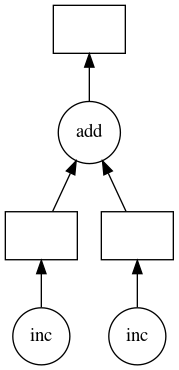

In [21]:
%%time

# z = lazy dask.Delayed object
z.compute()  # Actual result of computation
z.visualize()  # Visualize computation graph

Before computing: Delayed('sum-4ece6e78-027d-4ddd-8dd8-e06a90546462')
After computing : 44
CPU times: user 58.7 ms, sys: 12.4 ms, total: 71.1 ms
Wall time: 118 ms


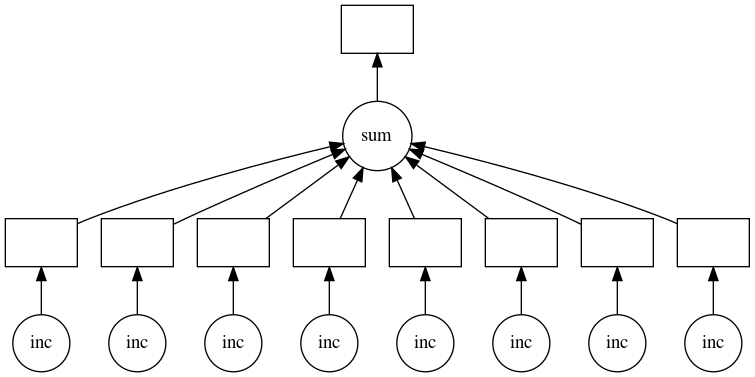

In [23]:
%%time

data = [1, 2, 3, 4, 5, 6, 7, 8]
results = []

for x in data:
    y = delayed(inc)(x)  # Reminder: doesn't actually perform computation here
    results.append(y)  # Add dask.Delayed object to list

# Params = list of dask.Delayed objects, total = dask.Delayed object (contains computation graph)
# 
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed
total.visualize()

In [7]:
metadata_filename = "metadata.csv"
metadata_cols = list(pd.read_csv(metadata_filename, nrows=0).columns)
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_dd = dd.read_csv(metadata_filename, dtype=metadata_cols_dtypes)

In [8]:
print(f"Num rows before: {metadata_dd.shape[0].compute()}")
metadata_dd = metadata_dd.dropna(subset=["title"], how="all")
metadata_dd = metadata_dd.dropna(subset=["abstract", "url"], how="all")
print(f"Num rows before: {metadata_dd.shape[0].compute()}")
print(f"Null cols before: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")
metadata_dd = metadata_dd.fillna("")
print(f"Null cols after: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")

Num rows before: 379974
Num rows before: 328190
Null cols before: ['sha', 'doi', 'pmcid', 'pubmed_id', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']
Null cols after: []


In [6]:
print(f"Metadata df shape: {metadata_dd.shape}")  # (Delayed shape, # cols)
print(f"Metadata dd memory usage: {metadata_dd.memory_usage()}")
print(f"Metadata dd types: {metadata_dd.dtypes}")
metadata_dd

(Delayed('int-334036e0-a895-4ee0-bc01-6f80b06c8573'), 19)
Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: series-groupby-sum-agg, 75 tasks
cord_uid            object
sha                 object
source_x            object
title               object
doi                 object
pmcid               object
pubmed_id           object
license             object
abstract            object
publish_time        object
authors             object
journal             object
mag_id              object
who_covidence_id    object
arxiv_id            object
pdf_json_files      object
pmc_json_files      object
url                 object
s2_id               object
dtype: object


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
npartitions=9,,,,,,,,,,,,,,,,,,,
,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
